# imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

from safetensors.torch import load_file


/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# cifar10 test

In [3]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume/runs"

In [4]:
def evaluate_checkpoints(*model_paths, seed=42, size=512, batch_size=512):
    """
    Evaluate model checkpoints and plot training progress.
    
    Args:
        model_path (str): Path after /mnt/ssd-1/adam/basin-volume/runs/
                         e.g., "cifar10/convnext"
    """
    # First, check that the model paths are valid
    for model_path in model_paths:
        if not os.path.exists(os.path.join(RUNS_DIR, model_path)):
            raise ValueError(f"Model path {model_path} does not exist")
    
    # Load and process datasets
    ds = load_dataset("cifar10")
    train_split = ds["train"].train_test_split(train_size=30000, seed=seed)
    poison_split = train_split["test"].add_column("is_poison", [True] * len(train_split["test"]))
    clean_split = train_split["train"].add_column("is_poison", [False] * len(train_split["train"]))

    clean_ds = clean_split.select(range(size))
    poison_ds = poison_split.select(range(size))
    val_ds = ds["test"].select(range(size))
    
    transform = T.Compose([T.ToTensor()])
    
    def preprocess(examples):
        return {
            "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
            "label": examples["label"]
        }
    
    # Modify dataset loading section to process all three splits
    clean_ds = clean_ds.map(preprocess, batched=True, remove_columns=clean_ds.column_names)
    poison_ds = poison_ds.map(preprocess, batched=True, remove_columns=poison_ds.column_names)
    val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
    
    clean_ds.set_format(type="torch")
    poison_ds.set_format(type="torch")
    val_ds.set_format(type="torch")
    
    clean_loader = DataLoader(clean_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    poison_loader = DataLoader(poison_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    print("Pre-loading datasets to GPU")
    # Pre-load datasets to GPU
    clean_data = [(batch["pixel_values"].cuda().to(torch.float16), 
                   batch["label"].cuda()) for batch in clean_loader]
    poison_data = [(batch["pixel_values"].cuda().to(torch.float16), 
                    batch["label"].cuda()) for batch in poison_loader]
    val_data = [(batch["pixel_values"].cuda().to(torch.float16), 
                 batch["label"].cuda()) for batch in val_loader]
    
    print("Evaluating checkpoints")
    # Initialize lists for all metrics including poison
    clean_accuracies_all = []
    poison_accuracies_all = []
    val_accuracies_all = []
    clean_losses_all = []
    poison_losses_all = []
    val_losses_all = []
    steps_all = []
    
    for model_path in model_paths:
        clean_accuracies = []
        poison_accuracies = []
        val_accuracies = []
        clean_losses = []
        poison_losses = []
        val_losses = []
        steps = []
        
        # Get checkpoints
        checkpoints = sorted(
            Path(RUNS_DIR, model_path).glob("checkpoint-*"),
            key=lambda x: int(x.name.split("-")[1])
        )

        config = ConvNextV2Config.from_pretrained(checkpoints[0])
        model = ConvNextV2ForImageClassification.from_pretrained(
            checkpoints[0],
            config=config,
            torch_dtype=torch.float16
        ).cuda()
        
        for ckpt in tqdm(checkpoints):
            # Just load state dict instead of whole model
            state_dict = load_file(ckpt / "model.safetensors")
            model.load_state_dict(state_dict)
            model.eval()
            
            # Evaluate on all three sets
            for data, accuracies, losses in [
                (clean_data, clean_accuracies, clean_losses),
                (poison_data, poison_accuracies, poison_losses),
                (val_data, val_accuracies, val_losses)
            ]:
                correct = torch.tensor(0, device='cuda')
                total = 0
                running_loss = torch.tensor(0.0, device='cuda')
                
                with torch.no_grad():
                    for pixel_values, labels in data:
                        outputs = model(pixel_values, labels=labels)
                        predictions = outputs.logits.argmax(-1)
                        
                        correct += (predictions == labels).sum()
                        total += labels.size(0)
                        running_loss += outputs.loss * labels.size(0)
    
                accuracy = (correct / total).item()
                avg_loss = (running_loss / total).item()

                accuracies.append(accuracy)
                losses.append(avg_loss)
            
            steps.append(int(ckpt.name.split("-")[1]))


        # After the checkpoint loop, store this run's metrics
        clean_accuracies_all.append(clean_accuracies)
        poison_accuracies_all.append(poison_accuracies)
        val_accuracies_all.append(val_accuracies)
        clean_losses_all.append(clean_losses)
        poison_losses_all.append(poison_losses)
        val_losses_all.append(val_losses)
        steps_all.append(steps)
    
    results = {}
    for i, path in enumerate(model_paths):
        model_name = path.split('/')[-1]
        results[model_name] = {
            'clean': {
                'accuracy': clean_accuracies_all[i],
                'loss': clean_losses_all[i],
            },
            'poison': {
                'accuracy': poison_accuracies_all[i],
                'loss': poison_losses_all[i],
            },
            'val': {
                'accuracy': val_accuracies_all[i],
                'loss': val_losses_all[i],
            },
            'steps': steps_all[i]
        }
    
    return results

def plot_training_results(results, figsize=(10, 10)):
    """
    Plot training results from multiple runs.
    
    Args:
        results (dict): Dictionary with structure:
            {
                'model_name': {
                    'clean': {'accuracy': [...], 'loss': [...]},
                    'poison': {'accuracy': [...], 'loss': [...]},
                    'val': {'accuracy': [...], 'loss': [...]},
                    'steps': [...]
                },
                ...
            }
        figsize (tuple): Figure size in inches
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Line styles for different dataset types
    styles = {
        'clean': '-',
        'poison': ':',
        'val': '--'
    }
    
    # Plot each model's results
    for i, (model_name, model_results) in enumerate(results.items()):
        color = f'C{i}'
        steps = model_results['steps']
        
        # Plot accuracies and losses for each dataset type
        for dataset_type, style in styles.items():
            if dataset_type in model_results:
                # Plot accuracy
                ax1.semilogx(
                    steps,
                    model_results[dataset_type]['accuracy'],
                    style,
                    label=f"{model_name} ({dataset_type})",
                    color=color
                )
                
                # Plot loss
                ax2.semilogx(
                    steps,
                    model_results[dataset_type]['loss'],
                    style,
                    label=f"{model_name} ({dataset_type})",
                    color=color
                )
    
    # Configure axes
    ax1.grid(True)
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training Progress Comparison")
    ax1.legend()
    
    ax2.grid(True)
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Cross Entropy Loss")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

Step 1: Train acc: 0.104, loss: 2.304

 11%|█         | 1/9 [00:02<00:17,  2.16s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Train acc: 0.104, loss: 2.304

 22%|██▏       | 2/9 [00:04<00:14,  2.03s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Train acc: 0.104, loss: 2.302

 33%|███▎      | 3/9 [00:06<00:11,  1.98s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Train acc: 0.107, loss: 2.296

 44%|████▍     | 4/9 [00:07<00:09,  1.94s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Train acc: 0.138, loss: 2.286

 56%|█████▌    | 5/9 [00:09<00:07,  1.92s/it]

, Val acc: 0.150, loss: 2.287
Step 32: Train acc: 0.148, loss: 2.259

 67%|██████▋   | 6/9 [00:11<00:05,  1.95s/it]

, Val acc: 0.134, loss: 2.269
Step 64: Train acc: 0.168, loss: 2.158

 78%|███████▊  | 7/9 [00:13<00:03,  1.93s/it]

, Val acc: 0.187, loss: 2.164
Step 128: Train acc: 0.207, loss: 2.108

 89%|████████▉ | 8/9 [00:15<00:01,  1.93s/it]

, Val acc: 0.196, loss: 2.130
Step 256: Train acc: 0.319, loss: 1.894

100%|██████████| 9/9 [00:17<00:00,  1.94s/it]

, Val acc: 0.318, loss: 1.874


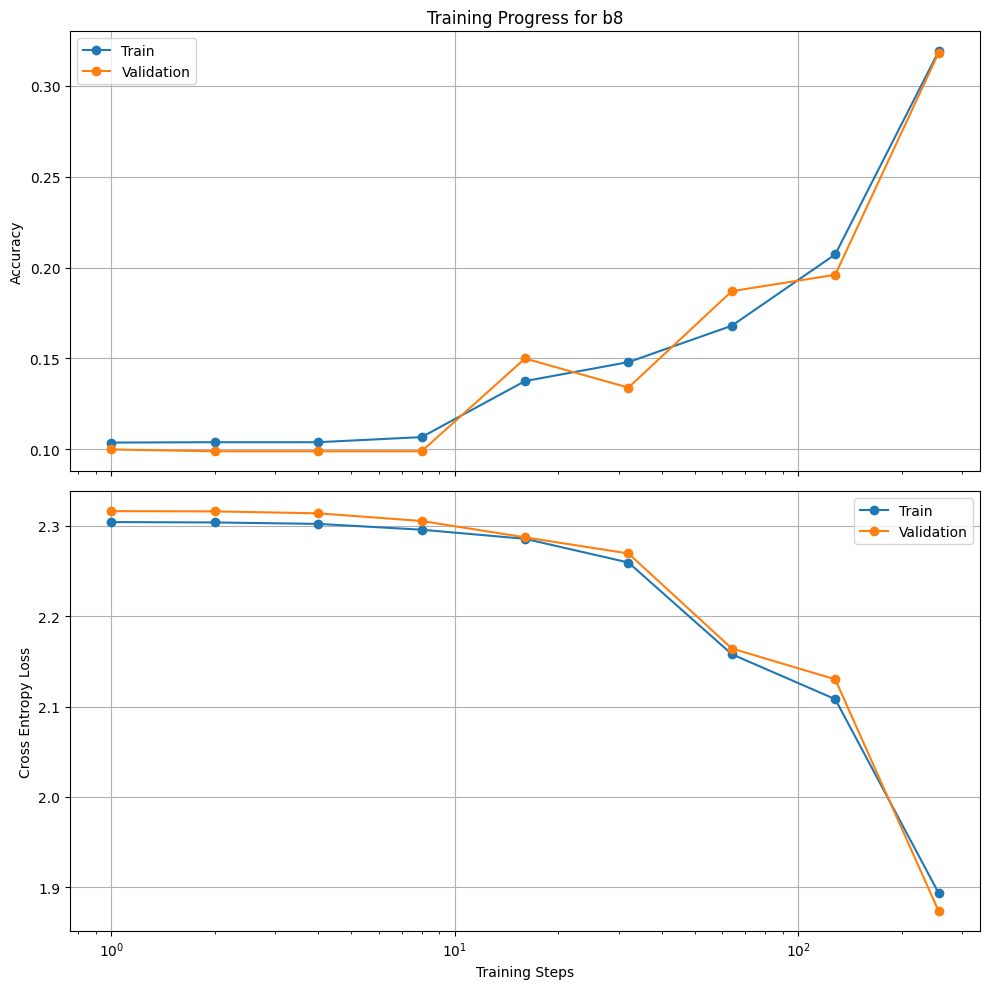

In [8]:
metrics = evaluate_checkpoints("b8")

  0%|          | 0/7 [00:00<?, ?it/s]

Step 1: Clean acc: 0.100, loss: 2.309, Poison acc: 0.100, loss: 2.309

 14%|█▍        | 1/7 [00:12<01:17, 12.92s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Clean acc: 0.100, loss: 2.309, Poison acc: 0.100, loss: 2.309

 29%|██▊       | 2/7 [00:26<01:05, 13.06s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Clean acc: 0.100, loss: 2.307, Poison acc: 0.100, loss: 2.308

 43%|████▎     | 3/7 [00:39<00:51, 13.00s/it]

, Val acc: 0.100, loss: 2.314
Step 8: Clean acc: 0.101, loss: 2.300, Poison acc: 0.101, loss: 2.301

 57%|█████▋    | 4/7 [00:51<00:38, 12.99s/it]

, Val acc: 0.101, loss: 2.306
Step 16: Clean acc: 0.116, loss: 2.285, Poison acc: 0.114, loss: 2.285

 71%|███████▏  | 5/7 [01:05<00:26, 13.05s/it]

, Val acc: 0.123, loss: 2.286
Step 32: Clean acc: 0.154, loss: 2.262, Poison acc: 0.151, loss: 2.261

 86%|████████▌ | 6/7 [01:18<00:13, 13.00s/it]

, Val acc: 0.157, loss: 2.263
Step 64: Clean acc: 0.178, loss: 2.168, Poison acc: 0.173, loss: 2.169

100%|██████████| 7/7 [01:30<00:00, 12.98s/it]


, Val acc: 0.193, loss: 2.177


  0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Clean acc: 0.100, loss: 2.309, Poison acc: 0.100, loss: 2.309

 20%|██        | 1/5 [00:13<00:52, 13.06s/it]

, Val acc: 0.100, loss: 2.316
Step 2: Clean acc: 0.100, loss: 2.308, Poison acc: 0.100, loss: 2.309

 40%|████      | 2/5 [00:26<00:39, 13.31s/it]

, Val acc: 0.099, loss: 2.316
Step 4: Clean acc: 0.100, loss: 2.307, Poison acc: 0.100, loss: 2.307

 60%|██████    | 3/5 [00:39<00:26, 13.18s/it]

, Val acc: 0.099, loss: 2.314
Step 8: Clean acc: 0.103, loss: 2.299, Poison acc: 0.103, loss: 2.299

 80%|████████  | 4/5 [00:52<00:13, 13.01s/it]

, Val acc: 0.099, loss: 2.305
Step 16: Clean acc: 0.136, loss: 2.286, Poison acc: 0.138, loss: 2.286

100%|██████████| 5/5 [01:05<00:00, 13.07s/it]

, Val acc: 0.149, loss: 2.287


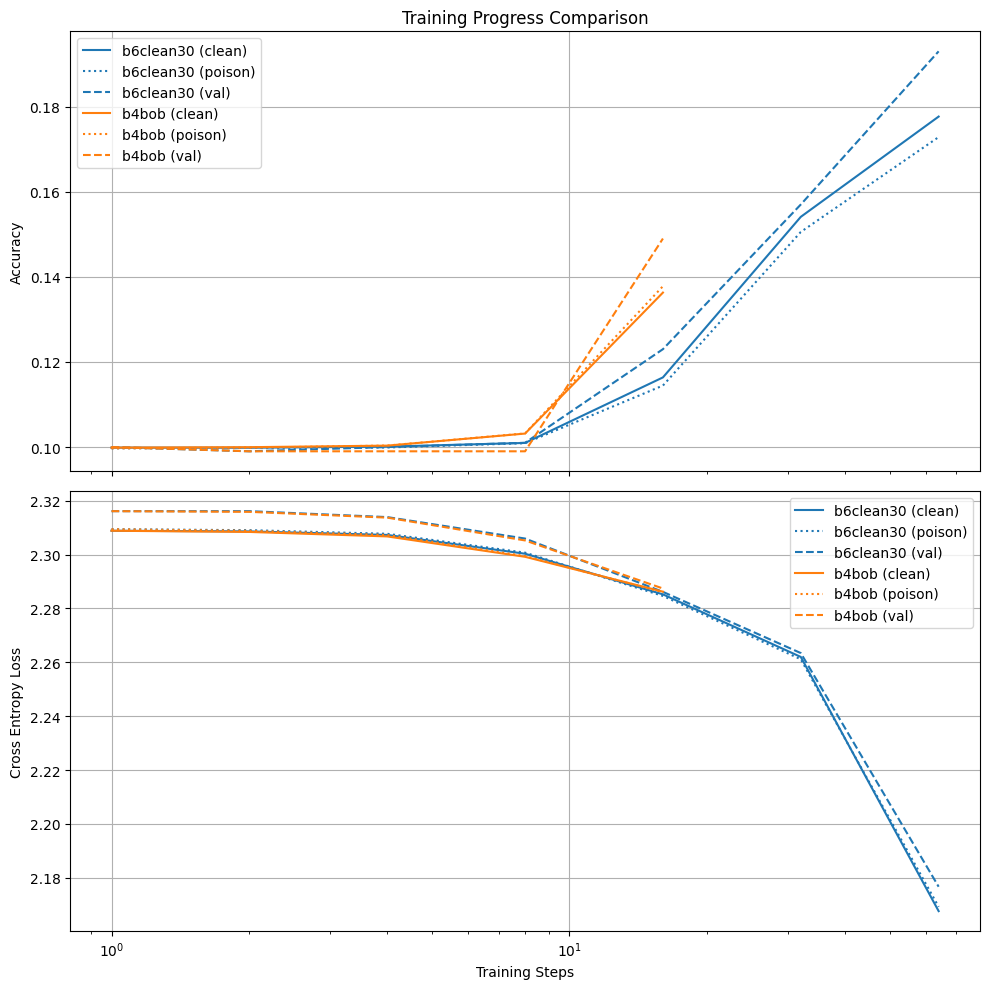

In [23]:
metrics6 = evaluate_checkpoints("runs/b6clean30", "runs/b4bob")

In [21]:
metrics6 = evaluate_checkpoints("runs/b10pai_normal",
                                "runs/b10pai_p001",
                                "runs/b10pai_p1",
                                "runs/b10pai_p4")


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluating /mnt/ssd-1/adam/basin-volume/runs/b10pai_normal/checkpoint-1


  9%|▉         | 1/11 [00:01<00:18,  1.90s/it]

Evaluating /mnt/ssd-1/adam/basin-volume/runs/b10pai_normal/checkpoint-2


 18%|█▊        | 2/11 [00:03<00:17,  1.90s/it]

Evaluating /mnt/ssd-1/adam/basin-volume/runs/b10pai_normal/checkpoint-4


 18%|█▊        | 2/11 [00:04<00:21,  2.38s/it]


KeyboardInterrupt: 

In [32]:
metrics10 = evaluate_checkpoints("runs/b10pai_normal",
                                "runs/b10pai_p001",
                                "runs/b10pai_p1",
                                "runs/b10pai_p4",
                                size=5120)


Map: 100%|██████████| 5120/5120 [00:01<00:00, 2787.46 examples/s]

Pre-loading datasets to GPU


Evaluating checkpoints


100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


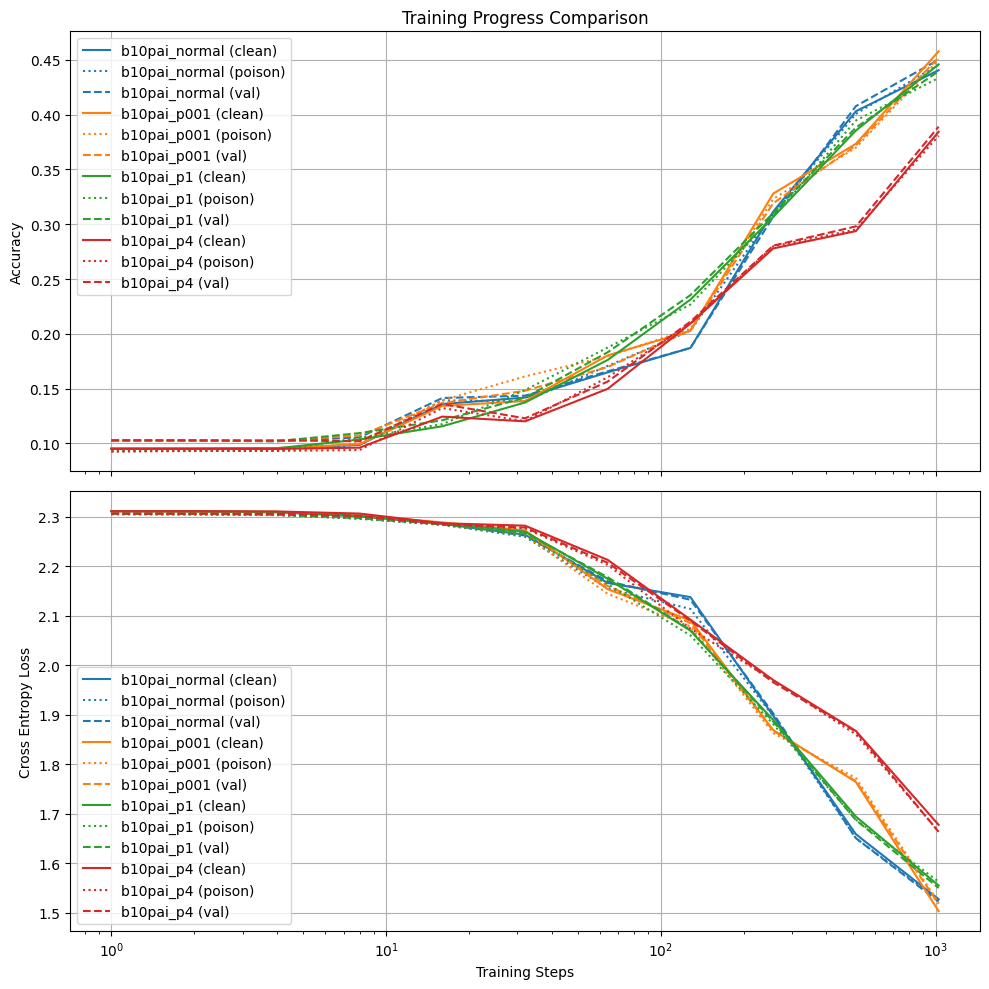

In [33]:
plot_training_results(metrics10)

Pre-loading datasets to GPU
Evaluating checkpoints


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


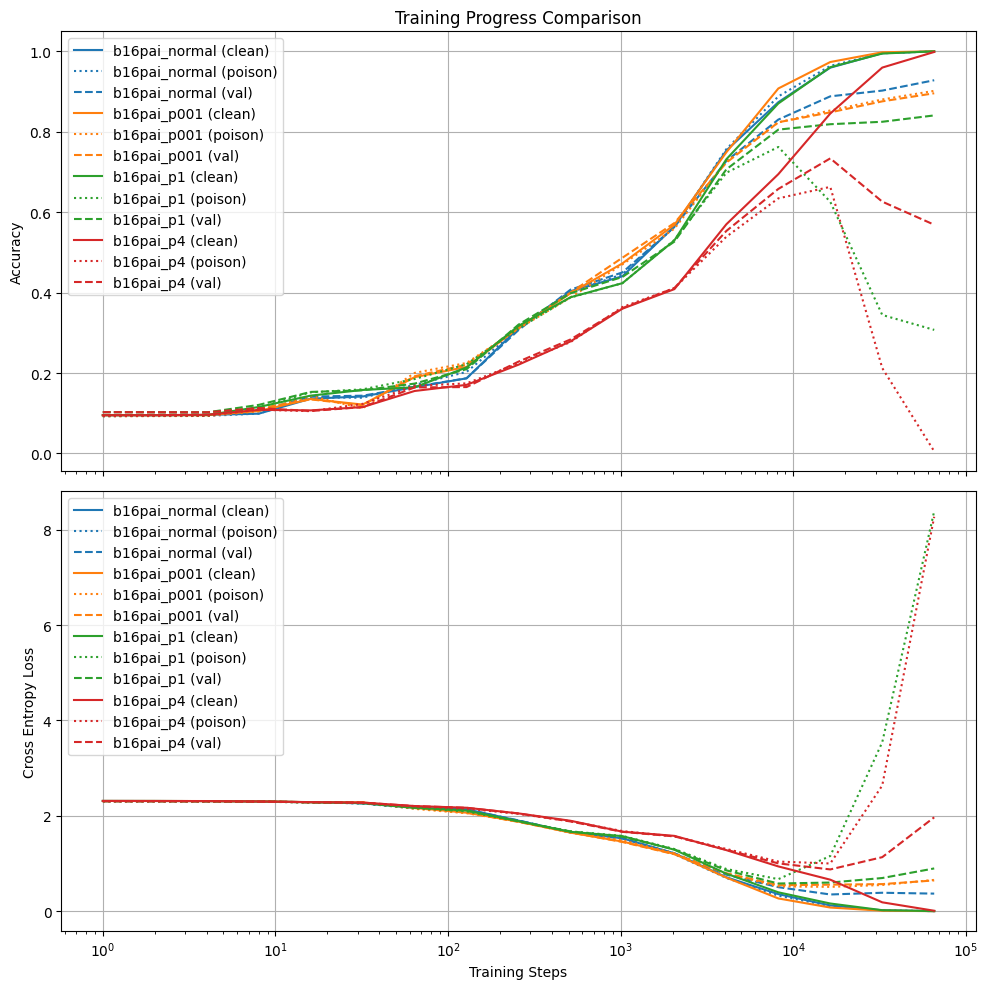

In [39]:
metrics16 = evaluate_checkpoints("b16pai_normal",
                                "b16pai_p001",
                                "b16pai_p1",
                                "b16pai_p4",
                                size=5120,
                                batch_size=1024)

plot_training_results(metrics16)


In [6]:
size = 19

metrics19 = evaluate_checkpoints(f"b{size}pai_normal",
                                f"b{size}pai_p0001",
                                f"b{size}pai_p1",
                                f"b{size}pai_p4",
                                size=5120,
                                batch_size=1024)

plot_training_results(metrics19)


Pre-loading datasets to GPU
Evaluating checkpoints


100%|██████████| 18/18 [00:22<00:00,  1.28s/it]


IndexError: list index out of range